In [21]:
#Resolve the required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # To visualize
from tabulate import tabulate #To create pretty tables
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from pprint import pprint
from scipy.interpolate import make_interp_spline, BSpline # To create smooth curves

In [22]:
#read in the data
base_directory = "/home/jeanpierre/LibraMetrics/containersMetricsFiles/Experiment4/250_tick_interval/2020_09_15__09_31_40/"
#base_directory = "/home/jeanpierre/libra2/libra2/experiments_logs/Experiment1/5_nodes/2020_09_10__01_32_36/"

files = ["merged/jp_mempool_process_incoming_transactions.csv", "merged/jp_consensus_process_proposal.csv", "merged/jp_consensus_process_new_round.csv"]

data_frames = []
for file_name in files:
    data_frame = pd.read_csv(base_directory + file_name, names=["txns", "duration"])
    data_frames.append(data_frame)

In [23]:
#Split the "jp_consensus_process_proposal.csv" into two parts,
#as the behaviour when #txns==0 and #txns>0 differs significantly
def split(arr, cond):
    return arr[cond], arr[~cond]

left, right = split(data_frames[1], data_frames[1]["txns"] == 0)
data_frames.append(right)
files.append("jp_consensus_process_proposal.csv WHERE #txns>0")

In [24]:
#convert duration from microseconds to milliseconds
i = 0
while i < len(data_frames):
    data_frames[i]["duration"] *= .001
    i += 1

left["duration"] *= 0.001

<ipython-input-24-6f1357628a3d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frames[i]["duration"] *= .001
<ipython-input-24-6f1357628a3d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left["duration"] *= 0.001


In [25]:
#Remove outliers that are >{std_from_mean}*std from the mean
std_from_mean = 3

mean_array = []
std_array = []
res_array = []

i = 0
while i < len(data_frames):
    data_frames[i] = data_frames[i][data_frames[i]['duration'].between(data_frames[i]['duration'].quantile(0), data_frames[i]['duration'].quantile(.999))]
    data_frames[i] = data_frames[i][data_frames[i]['txns'].between(data_frames[i]['txns'].quantile(0), data_frames[i]['txns'].quantile(.99))]

    mean = data_frames[i].groupby("txns").mean().reset_index()
    mean_array.append(mean)

    std = data_frames[i].groupby("txns").std().reset_index()
    std_array.append(std)
    
    std_mean = pd.merge(std, mean, on='txns', how='inner')
    std_mean.columns = ["txns", "std", "mean"]

    res = pd.merge(std_mean, data_frames[i], on='txns', how='inner')
    res = res[np.abs(res["duration"]-res["mean"]) <= (std_from_mean*res["std"])]
    res_array.append(res)
    print("Removed " + str(len(data_frames[i]) - len(res)) + " outliers out of " + str(len(data_frames[i])) + " entries")
    i += 1
    
left = left[left['duration'].between(left['duration'].quantile(0), left['duration'].quantile(.99))]

Removed 23285 outliers out of 2350409 entries
Removed 6572 outliers out of 617956 entries
Removed 1593 outliers out of 103010 entries
Removed 1749 outliers out of 161563 entries


In [26]:
print(res_array[1])

        txns        std        mean  duration
0          0   3.455003    7.944986     9.582
1          0   3.455003    7.944986     6.100
2          0   3.455003    7.944986     6.706
3          0   3.455003    7.944986     3.744
4          0   3.455003    7.944986     9.867
...      ...        ...         ...       ...
617951   149  95.819063  164.989033   225.302
617952   149  95.819063  164.989033   293.866
617953   149  95.819063  164.989033   189.920
617954   149  95.819063  164.989033   128.631
617955   149  95.819063  164.989033   282.999

[611384 rows x 4 columns]


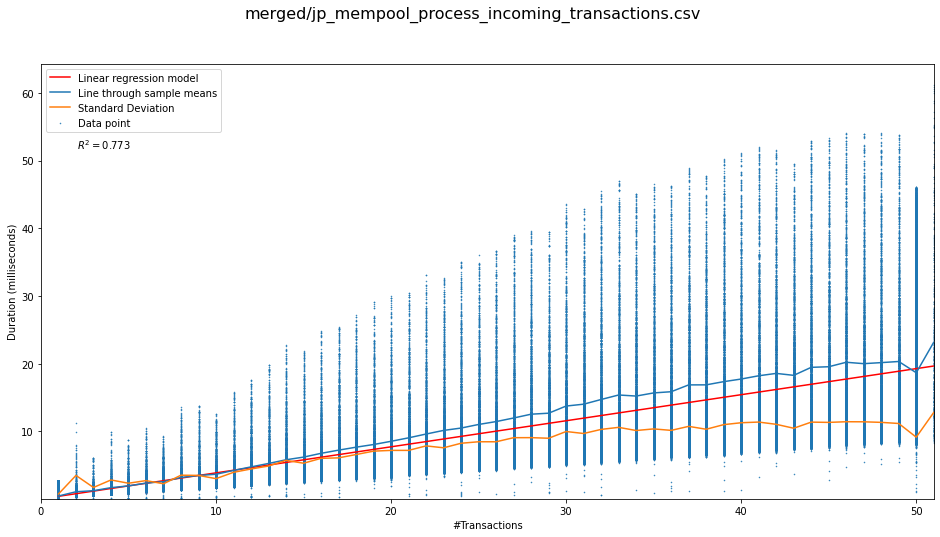

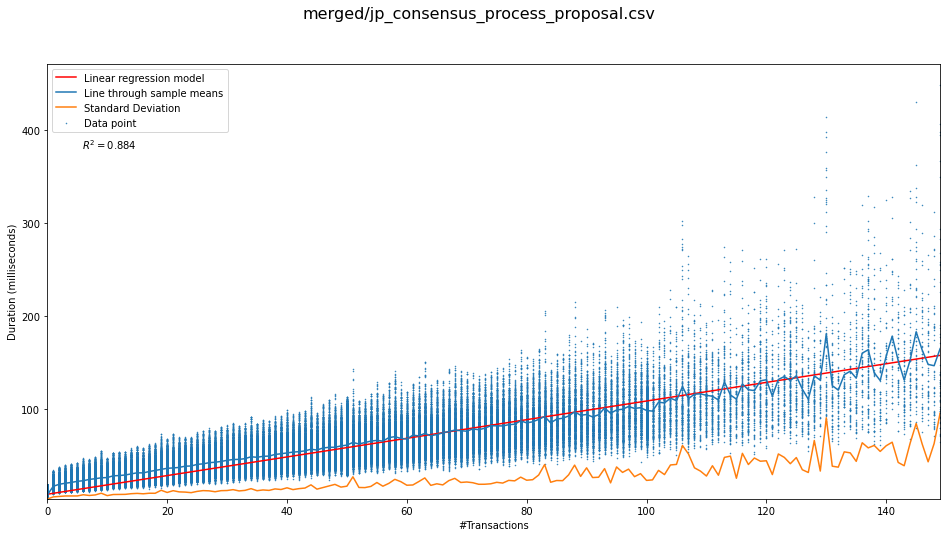

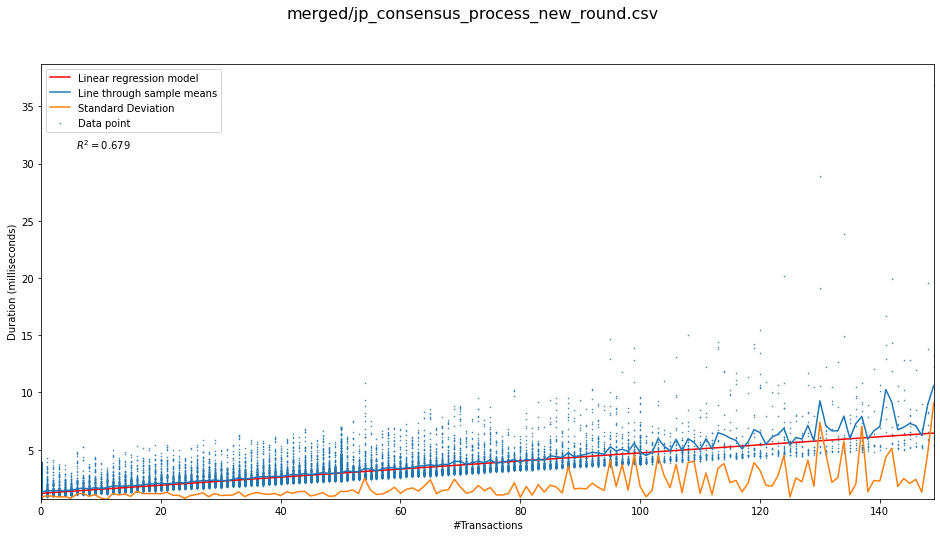

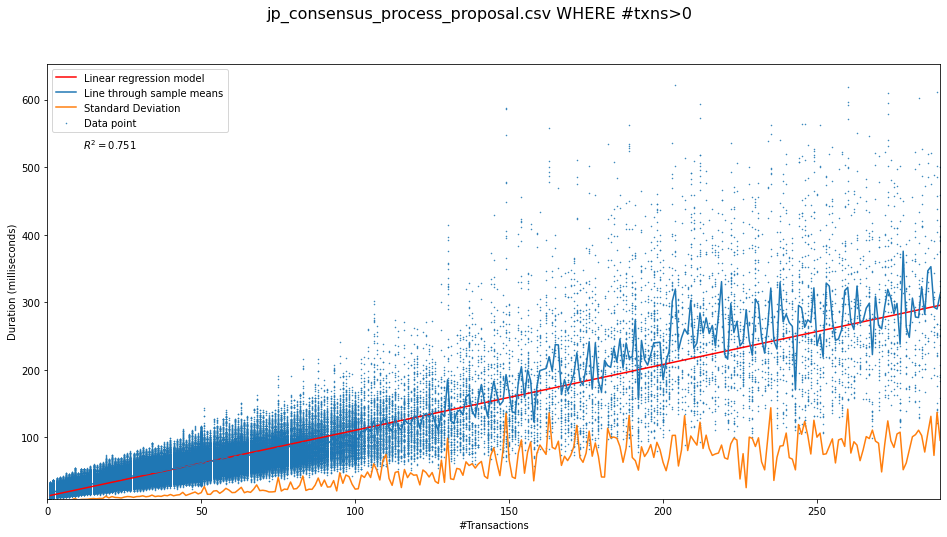

In [27]:
#Perform linear regression with R-sqaured score with pyplot
i = 0
while i < len(res_array):
    X = res_array[i].iloc[:, 0].values.reshape(-1, 1)
    Y = res_array[i].iloc[:, 3].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)

    fig = plt.figure(figsize=(16,8))
    fig.suptitle(files[i], fontsize=16)
    ax = fig.add_subplot()
    ax.set_xlabel('#Transactions')
    ax.set_ylabel('Duration (milliseconds)')

    ax.scatter(X, Y, marker='.', s=1, label='Data point')
    ax.plot(X, Y_pred, color='red', label='Linear regression model')

    coefficient_of_dermination = r2_score(Y, Y_pred)

    #plt.errorbar(mean["txns"], mean["duration"], yerr=0, capsize=5, label="errorbar")
    ax.plot(mean_array[i]["txns"], mean_array[i]["duration"], label="Line through sample means")
    ax.plot(std_array[i]["txns"], std_array[i]["duration"], label="Standard Deviation")

    ax.text(0.1, 0.8, "$R^2={0:.3f}$".format(coefficient_of_dermination), verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)
    plt.legend(loc='upper left')
    ax.set_xlim(0,X.max()) #X.max()
    ax.set_ylim(Y.min())
    #plt.savefig('pic.png')
    i += 1

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


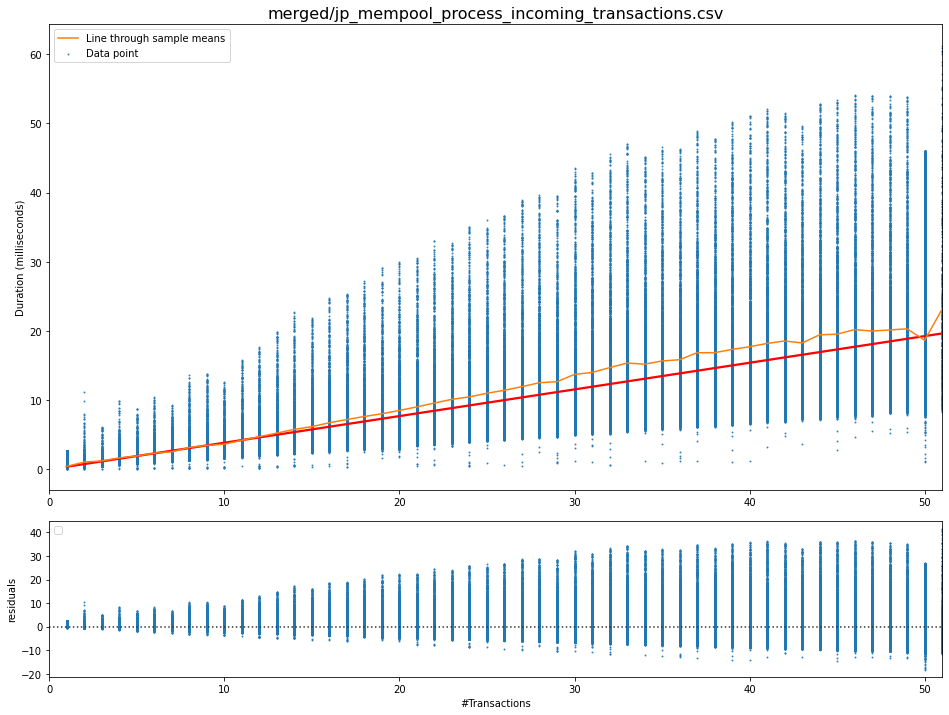

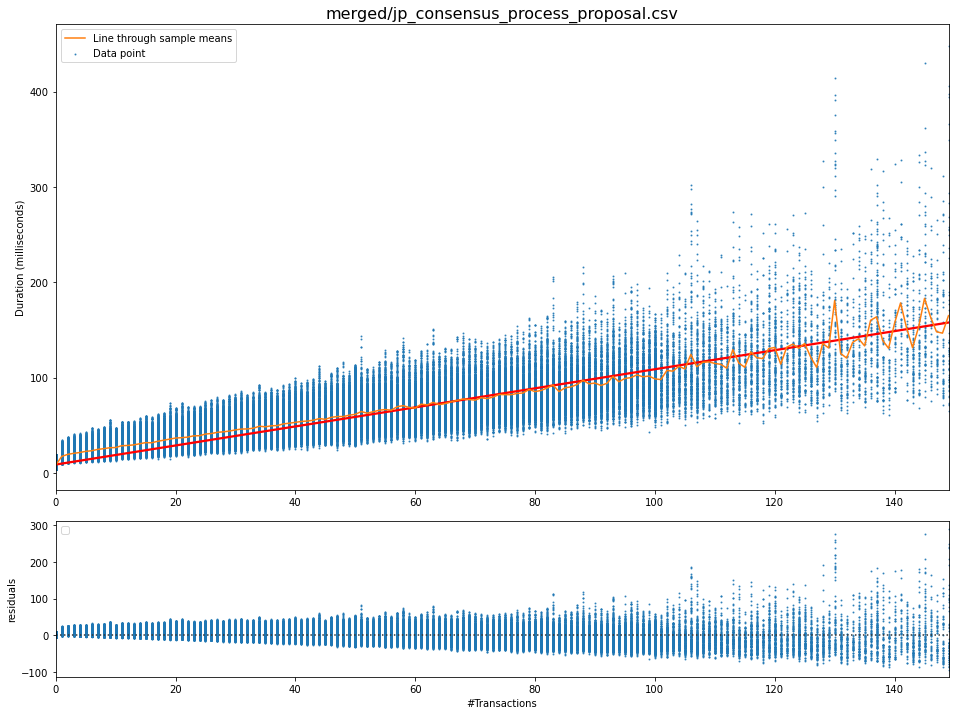

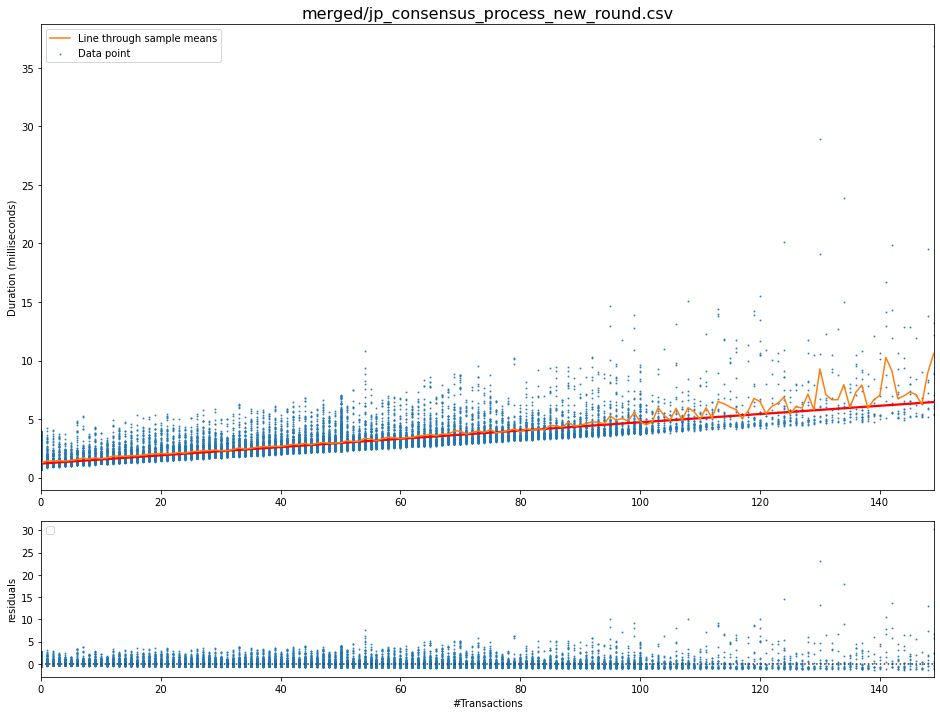

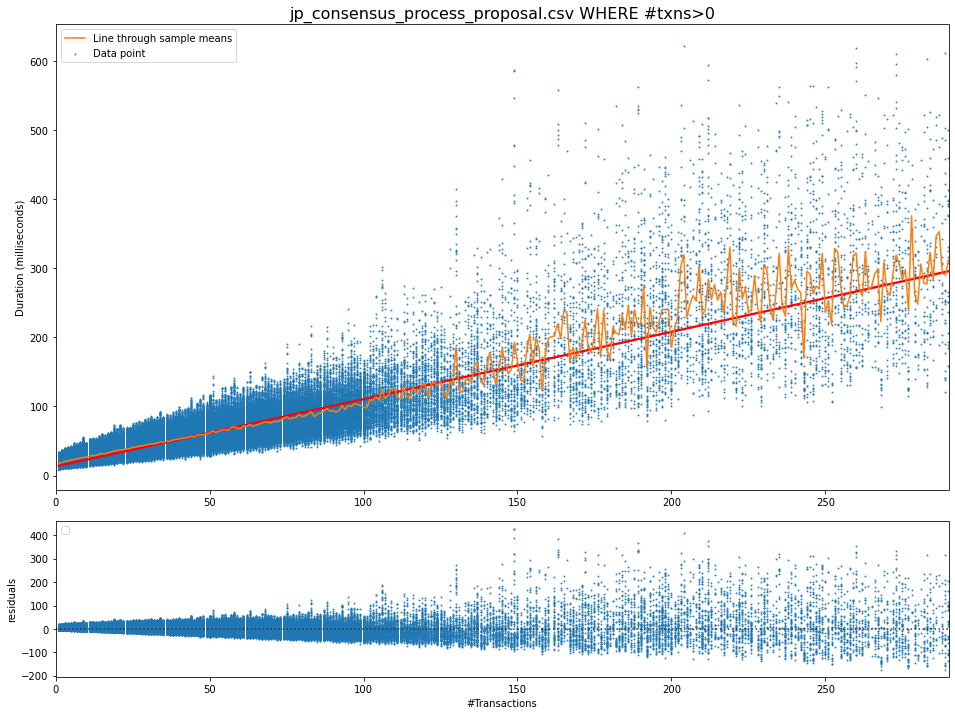

In [28]:
#Linear regression plot with Seaborn, showing a 95% confidence interval
i = 0
while i < len(res_array):
    fig, ax = plt.subplots(nrows=2, figsize=(16,12), gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})

    sns.regplot(x='txns', y='duration', data=res_array[i], ax=ax[0], ci=95, label='Data point', line_kws={"color": "red"}, scatter_kws={'s':1})
    sns.residplot(x='txns', y='duration', data=res_array[i], ax=ax[1], scatter_kws={'s':1})
    ax[0].plot(mean_array[i]["txns"], mean_array[i]["duration"], label="Line through sample means")

    ax[0].set_title(files[i], fontsize=16)
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Duration (milliseconds)")
    ax[0].set_xlim(left=0, right=res_array[i]['txns'].max())
    ax[0].legend(loc='upper left')

    ax[1].set_xlabel("#Transactions")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim(left=0, right=ax[0].get_xlim()[1])
    ax[1].legend(loc='upper left')
    i += 1

In [29]:
def create_four_dist_plots(title, data):
    fig, ax = plt.subplots(2, 2, figsize=(16,8))
    plt.subplots_adjust(hspace=0.5)
    sns.distplot(data, ax=ax[0][0], bins=50)
    sns.boxplot(data, ax=ax[0][1], fliersize=1, linewidth=1)
    sns.boxenplot(data, ax=ax[1][0])
    sns.violinplot(data, ax=ax[1][1], inner='quartile')

    fig.suptitle(title, fontsize=16)
    ax[0,0].set_title("Distribution")
    ax[0,1].set_title("Boxplot")
    ax[1,0].set_title("Boxenplot")
    ax[1,1].set_title("Violinplot")

    ax[0,0].set_xlabel("Duration (milliseconds)")
    ax[0,1].set_xlabel("Duration (milliseconds)")
    ax[1,0].set_xlabel("Duration (milliseconds)")
    ax[1,1].set_xlabel("Duration (milliseconds)")

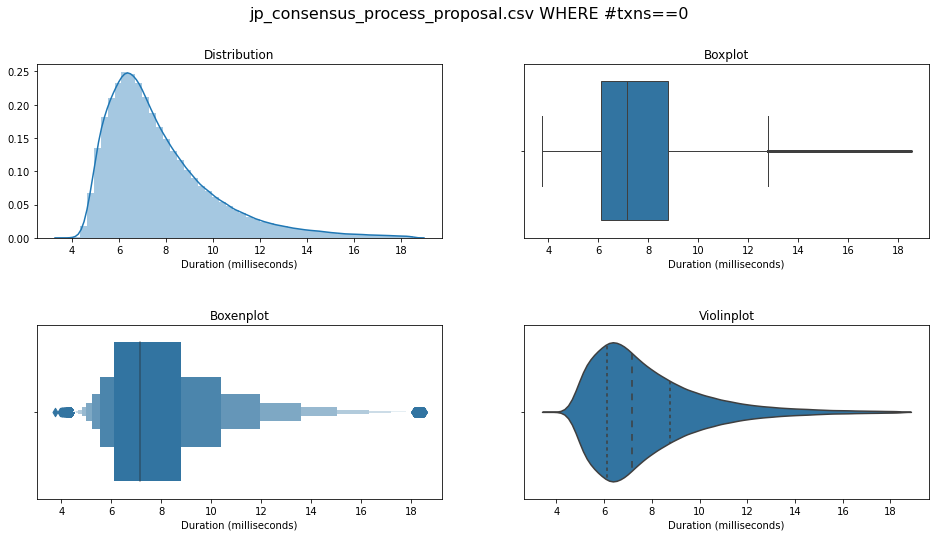

In [30]:
create_four_dist_plots("jp_consensus_process_proposal.csv WHERE #txns==0", left['duration'])

In [31]:
def get_counts_per_timewindow(X, nr_bins):
    X_res = []
    Y_res = []

    end_time = max(X)
    part = end_time/nr_bins
    for x in range(nr_bins):
        position = (part * x) + (0.5 * part)
        X_res.append(position)

        y_part = X[(X >= (part * x)) & (X < (part * (x+1)))]
        Y_res.append(len(y_part)/part)
    return X_res, Y_res

Average Throughput: 603.4451059939179
Maximum Throughput: 421.34 at time: 3165


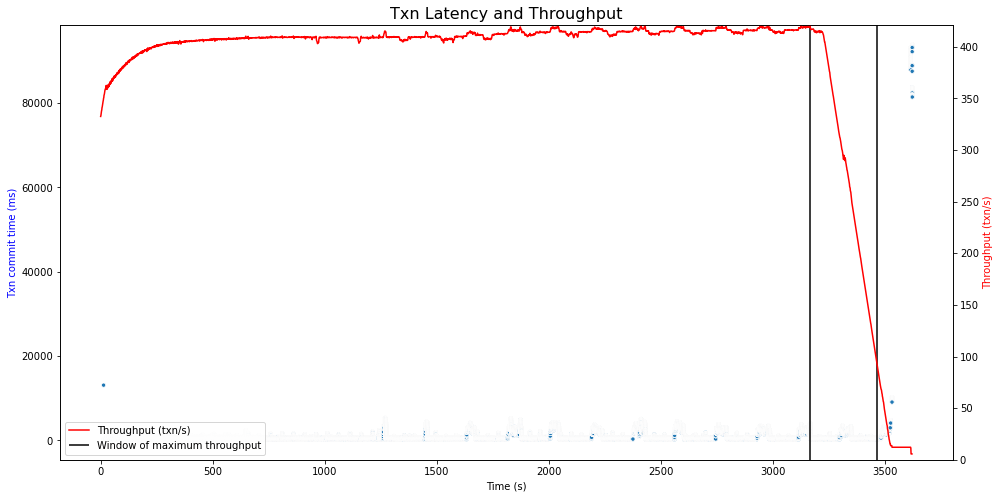

In [32]:
#Load in both client txns start time and end times
ac_dataframe = pd.read_csv(base_directory + "merged/jp_ac_client_transaction.csv", names=["address", "sequence_number", "timestamp"])
f = open(base_directory + "merged/jp_blockstore_process_block.csv")
lines = f.read().split("\n")
f.close()

dictionary = {"address":[], "sequence_number":[], "timestamp":[]}

#Parse blockstore into a dataframe
for x in range(len(lines)):
    line = lines[x].replace('"', '')
    parts = line.split(",")

    timestamp = parts[0]
    for y in range(1, len(parts)):
        acc_seq = parts[y].split(":")
        dictionary["address"].append(acc_seq[0])
        dictionary["sequence_number"].append(acc_seq[1])
        dictionary["timestamp"].append(timestamp)

blockstore_dataframe = pd.DataFrame(dictionary)
blockstore_dataframe[['sequence_number', 'timestamp']] = blockstore_dataframe[['sequence_number', 'timestamp']].apply(pd.to_numeric)

#left join to add commit times
result = pd.merge(ac_dataframe, blockstore_dataframe, how='left', on=['address', 'sequence_number'], suffixes=['_submit', '_commit'])
#remove the first and last 10% of the data
#result = result.head(int(len(result)*(90/100)))
#result = result.tail(int(len(result)*(90/100)))

#calculate the txn_latency and relative_txn_start_time, then add it to the result dataframe
txn_latency = result['timestamp_commit'] - result['timestamp_submit']
txn_rel_start_time = (result['timestamp_commit'] - result['timestamp_submit'].min())/1000
result['txn_latency(ms)'] = txn_latency
result['txn_rel_commit_time'] = txn_rel_start_time

result.sort_values(by=['timestamp_submit'], inplace=True, ignore_index=True)

#Finding the maximum throughput
X_res = []
Y_res = []
max_throughput = 0
max_throughput_time = 0
time_window = 300
for x in range(int(max(result['txn_rel_commit_time']))):
    rows = result.loc[(result['txn_rel_commit_time'] >= x) & (result['txn_rel_commit_time'] < x+time_window)]
    X_res.append(x)
    Y_res.append(len(rows) / time_window)
    if len(rows) > max_throughput:
        max_throughput = len(rows)
        max_throughput_time = x

#Create a scatterplot with 2 Y-axis, txn_latency and txn_througput
fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
sns.scatterplot(x=result['txn_rel_commit_time'], y=result['txn_latency(ms)'], label='Data point', size=1, ax=ax1)

ax2.plot(X_res, Y_res, color='red', label='Throughput (txn/s)')

#plot a vertical line at the maximum throughput
ax2.vlines([max_throughput_time, (max_throughput_time + time_window)], 0, max_throughput / time_window, label="Window of maximum throughput")

ax2.set_ylim(bottom=0, top=int(max_throughput / time_window))

ax1.set_title("Txn Latency and Throughput", fontsize=16)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Txn commit time (ms)', color='blue')
ax2.set_ylabel('Throughput (txn/s)', color='red')
ax1.get_legend().remove()
ax2.legend();

avg_throughput = len(result) / max(result['txn_rel_commit_time'])
print("Average Throughput: " + str(avg_throughput))
print("Maximum Throughput: " + str(max_throughput / time_window) + " at time: " + str(max_throughput_time))

,txn_latency(ms)
count,1.429857e+06
mean,1.020880e+03
std,4.451737e+03
min,7.300000e+01
25%,3.770000e+02
50%,4.780000e+02
75%,6.780000e+02
max,9.379500e+04


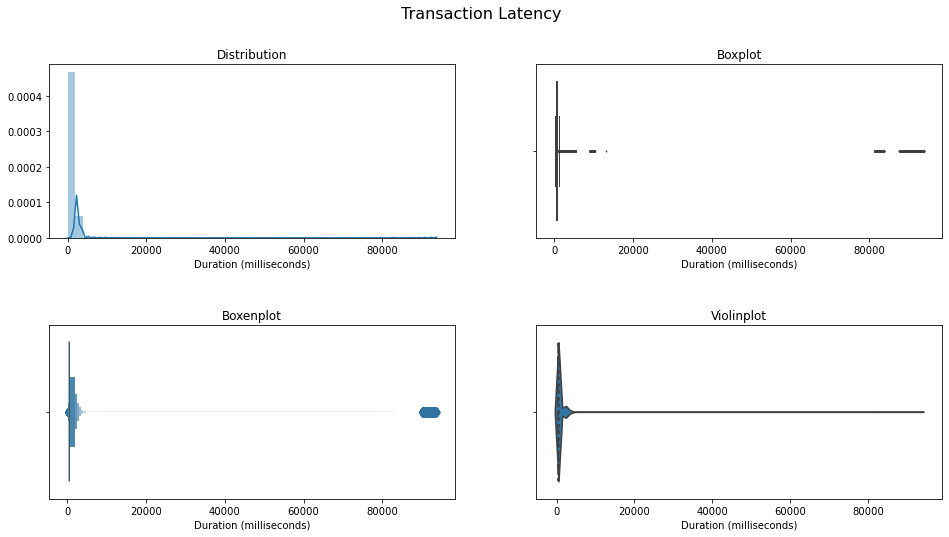

In [33]:
#Visualize txn_latency in distributions
create_four_dist_plots("Transaction Latency", result['txn_latency(ms)'])
result[['txn_latency(ms)']].describe()

In [34]:
#Put data points into 25 evenly divided bins and return the 15 largest bins
bins = left['duration'].value_counts(bins=25, sort=False).nlargest(15)
left = left[pd.cut(left['duration'], bins.index).notnull()]

left['shift'] = left['duration'] - min(left['duration'])

/home/jeanpierre/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Data points: 2168560
0.38018019233993405 0.15699999999999997 0.6124514159961985
alpha: KstestResult(statistic=0.03414684488419217, pvalue=0.0)
Other: KstestResult(statistic=0.4655225411803449, pvalue=0.0)


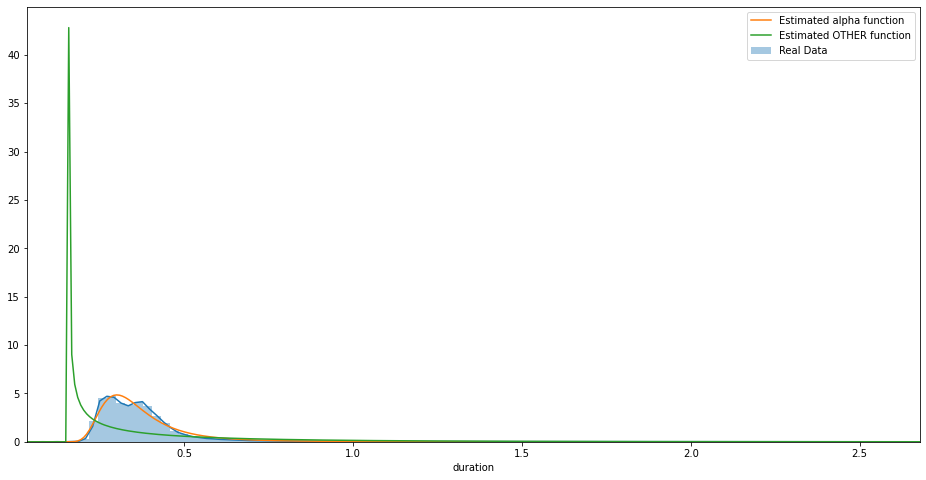

In [35]:
fig, ax = plt.subplots(figsize=(16,8))

model_number = 0
data = res_array[model_number][res_array[model_number]['txns'] == 1]['duration']

sns.distplot(data, ax=ax, label="Real Data", bins=100)

#Fitting the gamma distribution
x_min = min(data)
x_max = max(data)
X = np.linspace(x_min, x_max, 300)

fit_a_alpha, fit_loc_alpha, fit_scale_alpha = stats.alpha.fit(data)
fit_a, fit_loc, fit_scale = stats.gamma.fit(data)

alpha_fit = stats.alpha(fit_a_alpha, loc=fit_loc_alpha, scale=fit_scale_alpha)
gamma_fit = stats.gamma(fit_a, loc=fit_loc, scale=fit_scale)

#gamma_manual = stats.gamma(a=1.4, loc=0, scale=1.1)
ax.plot(X, alpha_fit.pdf(X), label="Estimated alpha function")
ax.plot(X, gamma_fit.pdf(X), label="Estimated OTHER function")
#ax.plot(X, gamma_manual.pdf(X), label="Manual gamma function")
ax.set_xlim(x_min, x_max)
ax.legend()
print("Data points:", len(data))
print(fit_a, fit_loc, fit_scale)

p_alpha_fit = stats.kstest(data, alpha_fit.cdf)
p_fit = stats.kstest(data, gamma_fit.cdf)
#p_manual = stats.kstest(data, gamma_manual.cdf)
print("alpha:", p_alpha_fit)
print("Other:", p_fit)
#print(p_manual)

In [36]:
#fig, ax = plt.subplots(figsize=(16,8))
#ecdf = ECDF(left['shift'])

#ax.plot(X, gamma_fit.cdf(X), label='fitted_CDF')
#ax.plot(X, gamma_manual.cdf(X), label='manual_CDF')
#ax.plot(ecdf.x, ecdf.y, label='empirical_CDF')
#ax.legend()

0.38018019233993405 0.15699999999999997 0.6124514159961985
#entries: 2168560
KstestResult(statistic=0.4655225411803449, pvalue=0.0)


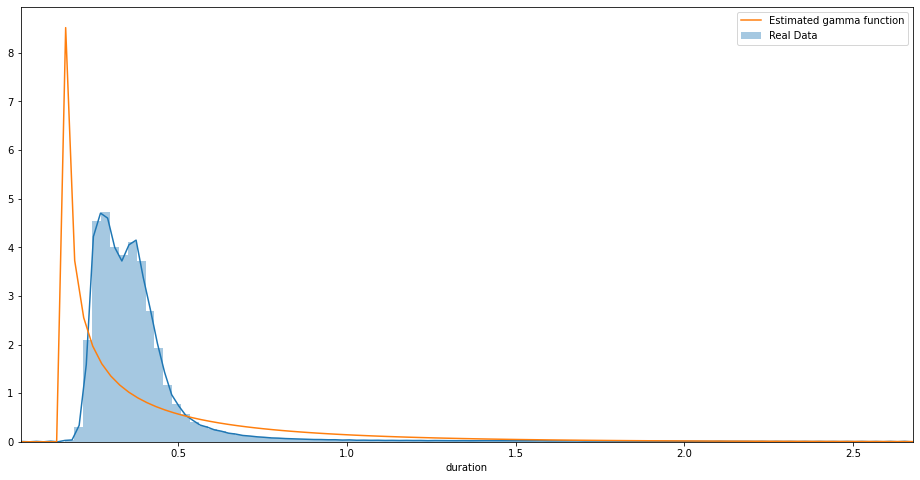

In [37]:
result = res_array[0][res_array[0]['txns'] == 1]

fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(result['duration'], ax=ax, label="Real Data", bins=100)

#Fitting the gamma distribution
X = np.linspace(result['duration'].min(), result['duration'].max(), 100)
fit_alpha, fit_loc, fit_scale = stats.gamma.fit(result['duration'])
gamma_fit = stats.gamma(a=fit_alpha, loc=fit_loc, scale=fit_scale)
ax.plot(X, gamma_fit.pdf(X), label="Estimated gamma function")
ax.set_xlim(X.min(), X.max())
ax.legend()
print(fit_alpha, fit_loc, fit_scale)

p_fit = stats.kstest(result['duration'], gamma_fit.cdf)
print("#entries:", result['txns'].count())
print(p_fit)

[0.0, 0.0, 6.070395938175984e-69, 1.57875815755448e-74, 4.869635293799776e-65, 2.0305443033871116e-55, 3.441568839431262e-52, 6.251519732142945e-57, 1.5132794757325612e-57, 3.2560376372612575e-43, 5.728126439848914e-42, 9.232430171910828e-54, 6.174734129737454e-45, 4.069408694585746e-45, 3.722108147483334e-43, 3.3304287097085323e-38, 3.007258420219092e-42, 4.9713878161595854e-23, 1.142777933074967e-31, 7.592285304782453e-22, 4.5136322737216126e-35, 6.525471968043785e-29, 2.0122963943819657e-10, 4.559496837648072e-24, 2.556977292598293e-25, 9.099548383150464e-22, 2.2301786183012162e-29, 5.869699133148271e-19, 1.9923001376314721e-16, 1.2563390086579864e-19, 1.0327254889396767e-21, 1.2050940337758848e-18, 0.009288642996703211, 3.0930696765994085e-18, 5.050692385614362e-18, 9.33963350854762e-14, 1.56610300127505e-14, 0.007535981887182398, 2.559984589296391e-17, 6.345738451830012e-13, 1.7580629682886962e-11, 9.118397808722393e-07, 1.2063473526709448e-09, 0.11111090967034709, 1.6900330795504

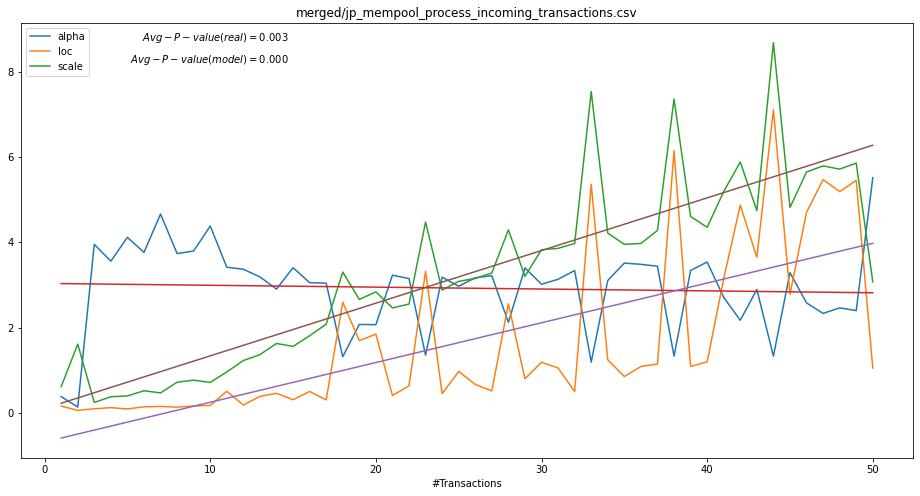

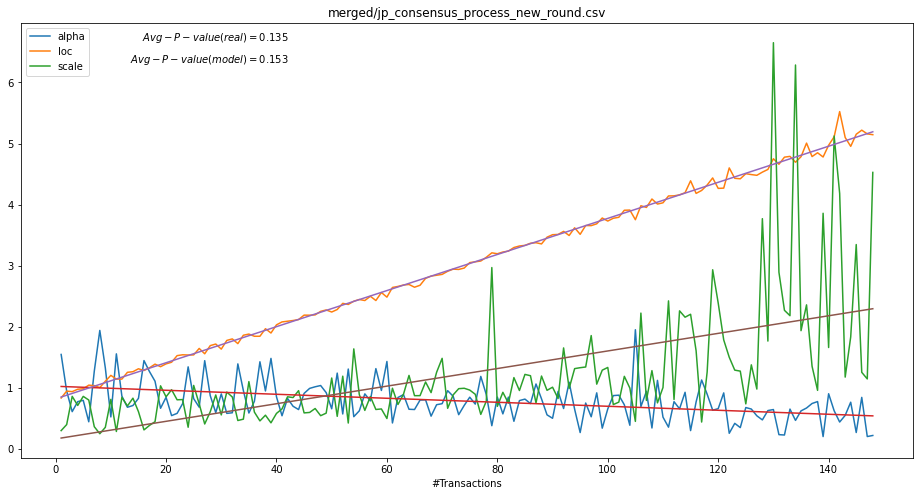

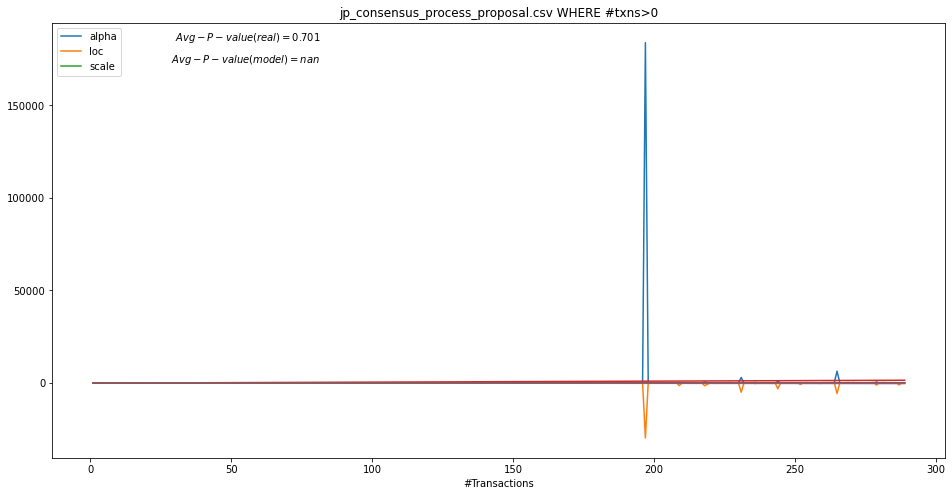

In [38]:
p_values_list_real = []
p_values_list_model = []

fit_alpha_list = []
fit_loc_list = []
fit_scale_list = []

model_nr = 0
while model_nr < len(res_array):
    #res_array[1] contains #txns==0
    if model_nr == 1:
        model_nr += 1
        p_values_list_real.append([])
        p_values_list_model.append([])
        continue
    
    #Fit and print the Gamma distribution parameters
    temp_fit_alpha = []
    temp_fit_loc = []
    temp_fit_scale = []
    temp_p_fit_real = []
    X = []
    #OLD X = np.linspace(0, max_txns, len(temp_fit_alpha)).reshape(-1,1)
    
    i = 1
    max_txns = max(res_array[model_nr]['txns']) - 1
    while i <= max_txns:
        data = res_array[model_nr][res_array[model_nr]['txns'] == i]['duration']
        if len(data) <= 1:
            i += 1
            continue
        fit_alpha, fit_loc, fit_scale = stats.gamma.fit(data)
        temp_fit_alpha.append(fit_alpha)
        temp_fit_loc.append(fit_loc)
        temp_fit_scale.append(fit_scale)

        p_fit = stats.kstest(data, stats.gamma(fit_alpha, loc=fit_loc, scale=fit_scale).cdf)
        temp_p_fit_real.append(p_fit[1])
        X.append(i)
        i += 1

    X = np.array(X).reshape(-1,1)
    
    fit_alpha_list.append(temp_fit_alpha)
    fit_loc_list.append(temp_fit_loc)
    fit_scale_list.append(temp_fit_scale)
    p_values_list_real.append(temp_p_fit_real)
    
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title(files[model_nr])
    ax.set_xlabel('#Transactions')
    
    ax.plot(X, temp_fit_alpha, label='alpha')
    ax.plot(X, temp_fit_loc, label='loc')
    ax.plot(X, temp_fit_scale, label='scale')
    ax.legend(loc='upper left')

    #Model the three gamma parameters into a linear fit
    linear_regressor_alpha = LinearRegression()
    linear_regressor_alpha.fit(X, temp_fit_alpha)
    Y_alpha_predictor = linear_regressor_alpha.predict(X)
    ax.plot(X, Y_alpha_predictor)

    linear_regressor_loc = LinearRegression()
    linear_regressor_loc.fit(X, temp_fit_loc)
    Y_loc_predictor = linear_regressor_loc.predict(X)
    ax.plot(X, Y_loc_predictor)

    linear_regressor_scale = LinearRegression()
    linear_regressor_scale.fit(X, temp_fit_scale)
    Y_scale_predictor = linear_regressor_scale.predict(X)
    ax.plot(X, Y_scale_predictor)

    #Calculate the p-values for the linear fit models
    temp_p_fit_model = []
    i = 0
    while i < len(X):
        data = res_array[model_nr][res_array[model_nr]['txns'] == X[i][0]]['duration']
            
        a_pred = linear_regressor_alpha.predict([[i]])
        loc_pred = linear_regressor_loc.predict([[i]])
        scale_pred = linear_regressor_scale.predict([[i]])

        p_fit = stats.kstest(data, stats.gamma(a_pred, loc=loc_pred, scale=scale_pred).cdf)
        temp_p_fit_model.append(p_fit[1])
        i += 1
        
    p_values_list_model.append(temp_p_fit_model)
    ax.text(0.3, 0.95, "$Avg-P-value(real)={:.3f}$".format(stats.describe(p_values_list_real[model_nr])[2]), verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
    ax.text(0.3, 0.9, "$Avg-P-value(model)={:.3f}$".format(stats.describe(p_values_list_model[model_nr])[2]), verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)

    model_nr += 1

i = 0
while i < len(p_values_list_real):
    if i == 1:
        i += 1
        continue
        
    print(p_values_list_real[i])
    print(stats.describe(p_values_list_real[i]))
    print()
    print(p_values_list_model[i])
    print(stats.describe(p_values_list_model[i]))
    print();
    i += 1
    
print(fit_alpha_list[2])
print()
print(fit_loc_list[2])
print()
print(fit_scale_list[2])

In [39]:
#Create and plot both the empirical/estimated batch processing times
X_data = []
Y_data = []

i = 1
while i <= 200:
    nr_txns = [[i]]
    a_pred = linear_regressor_alpha.predict(nr_txns)
    loc_pred = linear_regressor_loc.predict(nr_txns)
    scale_pred = linear_regressor_scale.predict(nr_txns)

    rvs = stats.gamma.rvs(a=a_pred, loc=loc_pred, scale=scale_pred, size=300)
    X_data.extend([i] * len(rvs))
    Y_data.extend(rvs)
    i += 1
  
fig, ax = plt.subplots(2, 1, figsize=(16,8))
ax[0].set_title("Empirical batch processing times")
ax[0].set_ylabel('Duration (ms)')
ax[0].scatter(res_array[3]['txns'], res_array[3]['duration'], marker='.', s=1, label='Data point');

ax[1].set_title("Predicted batch processing times")
ax[1].set_xlabel('#Transactions')
ax[1].set_ylabel('Duration (ms)')
ax[1].scatter(X_data, Y_data, marker='.', s=1, label='Data point');

max_y = max(max(res_array[3]['duration']), max(Y_data))
ax[0].set_ylim(0, max_y)
ax[1].set_ylim(0, max_y);

ValueError: Domain error in arguments.

In [ ]:
p_values_list_real = []
p_values_list_model = []

fit_alpha_list = []
fit_loc_list = []
fit_scale_list = []

#Fit and print the Gamma distribution parameters
i = 1
while i < 41:
    data = res_array[2][res_array[2]['txns'] == i]['duration']
    fit_alpha, fit_loc, fit_scale = stats.gamma.fit(data)
    fit_alpha_list.append(fit_alpha)
    fit_loc_list.append(fit_loc)
    fit_scale_list.append(fit_scale)
    
    p_fit = stats.kstest(data, stats.gamma(a=fit_alpha, loc=fit_loc, scale=fit_scale).cdf)
    p_values_list_real.append(p_fit[1])
    i += 1

pprint(p_values_list_real)
stats.describe(p_values_list_real)